# Make bar plots of ROH tracts
Make admixture style plots of ROH, both expected as well as for empirical Individuals

In [1]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as clb
import matplotlib.colors as cls
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import socket
import os as os
import sys as sys
import multiprocessing as mp

### For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

### To do lowess smoothing
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

sys.path.append("./PackagesSupport/")
from roh_expectations import Expected_Roh

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


### Calculate some expectations

In [6]:
def create_cousins_roh(degrees=[1,2,3], bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for Cousins of degree degrees [list]
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    c_roh = np.zeros((len(degrees),len(bins))) # Container for results Cousins
    for i,c in enumerate(degrees):
        for j,b in enumerate(bins):
            m = c*2 + 4
            c_roh[i,j] = e_roh.exp_roh_len_in_bin_rel(l=b, m=m, comm_anc=4, bins=10000)
    return c_roh

#bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]  # The bins I want to plot (eventually maybe do 12,16 as welll)
#cousins = [1, 2, 3]  # Which Cousins to Plot

def create_Ne_roh(Ns= [400, 800, 1600, 3200, 6400], bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]):
    """Create ROH sharing in list of bins (list of [begin,end]) 
    for Cousins of degree degrees [list]
    return sharing [len(degrees), len(bins)]"""
    e_roh = Expected_Roh()
    n_roh = np.zeros((len(Ns),len(bins))) # Container for results Cousins
    for i,N in enumerate(Ns):
        for j,b in enumerate(bins):
            n_roh[i,j] = e_roh.exp_roh_len_in_bin_N(b, N=N, bins=10000)
    return n_roh

In [45]:
%%time
bins = [[0.04,0.08],[0.08,0.12],[0.12,3.00]]
Ns=[400, 800, 1600, 3200, 6400]
degrees=[1,2,3]

### Calcualte Expectations Cousins:
c_roh = create_cousins_roh(degrees=degrees, bins = bins)

### Calculate Expectations Ne:
n_roh = create_Ne_roh(Ns=Ns, bins = bins)

CPU times: user 378 ms, sys: 1.67 ms, total: 380 ms
Wall time: 378 ms


In [17]:
c_roh
#np.sum(c_roh, axis=1)

array([[0.15417107, 0.1989896 , 1.79197005],
       [0.0579345 , 0.06908513, 0.39969971],
       [0.01947492, 0.02146337, 0.08786535]])

In [46]:
n_roh

array([[1.03261547, 0.35490188, 0.67148832],
       [0.53420341, 0.18084461, 0.33841895],
       [0.27173783, 0.09128736, 0.16988509],
       [0.13704896, 0.04586206, 0.08511232],
       [0.06882217, 0.02298589, 0.04259872]])

In [28]:
n_roh[:,2]/n_roh[:,0]

array([0.75462357, 0.68436315, 0.65027916, 0.63350204, 0.62518012,
       0.62103588, 0.61896795])

# Code for the Main Figure

### Idea:
Code should be very modular: The large figure uses gridspec to split 
up axis space, and on each axis I plot the bars, with legends / colors for populations below
(and maybe small age inlets).

The big code splits up the space according to sample Nr. The small axis do the plotting

### Do a subfigure

In [47]:
def plot_bar_ax(ax, fracs, bins=[], c=["royalblue", "gray", "coral"], x_ticks = ["1st C.", "2nd C.", "3rd C."], 
                ec = "silver", fs_l=10, fs = 10, fs_x=8, barWidth=0.95, ylim = [0,220], stds = [], title="", 
                yticks=False, legend=False, r_title=0):
    """Plot bars of ROH on Axis.
    ax: Where to Plot on
    fracs: Fractions of Expected ROH: [n Inds, n Bins]
    c: Which colors to plot
    bins: List of Bins (needed for legend - plotted if len()>0)
    yticks: Whether to plot Y tick Labels
    legend: Whether to plot Legend
    fs_x: Fontsize on the x Labels
    r_title: Rotation of the title"""
    y = fracs ### Fractions (along 1st axis length classses)
    x = np.arange(len(y))

    for i in range(len(y[0,:])): # From last to first (For Legend)
        b = np.sum(y[:,:i], axis=1)
        ax.bar(x, y[:,i], bottom=b, color=c[i], edgecolor=ec, width=barWidth, label=f"{bins[i,0]}-{bins[i,1]} cM", alpha=0.9)
        if len(stds)>0 and i>0: # Plot some standard deviations.
            ax1.errorbar(r, b, yerr=stds[:,i], fmt='none', linewidth=2, color="k")
    if legend:
        ax.legend(fontsize=fs_l, loc="upper right", title="Sum ROH in")
    ax.set_ylabel("Expected Sum ROH [cM]", fontsize=fs)
    ax.set_ylim(ylim)
    ax.set_xlim(x[0] - 0.7*barWidth, x[-1] + 0.7*barWidth)
    if len(x_ticks)>0:
        ax.set_xticks(x)
        ax.set_xticklabels(x_ticks, fontsize=fs_x, rotation=270)
    if not yticks:
        ax.set_yticklabels([])
        ax.set_ylabel("")
    if len(title)>0:
        ax.set_title(title, fontsize=fs, rotation=r_title)
        
def plot_panel_row(plot_dfs, wspace=0.05, hspace=0.01, figsize=(24,3.5), savepath="",
                   ylim = [0,250], r_title = 90, leg_pos = -2, show=True, title_col="clst"):
    """Plot row of ROH bin plots from plot_dfs (each df one panel)
    leg_pos = Where to plot legend (if outside range no legend plot)
    r_title: How much to rotate the title
    gs: Gridspec: If given plot on there"""
    bins_cM=(np.array(bins)*100).astype("int")
    n_plots = len(plot_dfs)+2
    width_ratios = [len(df) for df in plot_dfs]+[len(c_roh),len(n_roh)]
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, n_plots, width_ratios=width_ratios, figure=fig)
    
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    for i,df in enumerate(plot_dfs):   
        if i==0:
            ytick=True
        else:
            ytick=False

        if i == (len(plot_dfs) + leg_pos):
            legend=True
        else:
            legend=False

        ax = plt.subplot(gs[i])    # Extract the Sub Plot to Plot onto
        obs_roh = df[cols].values
        obs_roh[:,0] = obs_roh[:,0] - obs_roh[:,1]
        obs_roh[:,1] = obs_roh[:,1] - obs_roh[:,2]
        obs_roh[:,2] = obs_roh[:,2]

        plot_bar_ax(ax, obs_roh, bins_cM, yticks=ytick, legend=legend, r_title=r_title,
                    x_ticks = df["iid"].values, title=df[title_col].values[0], ylim=ylim)

    #### Plot the legend bars:
    ### 1) Small Pops
    ax = plt.subplot(gs[-2])    # The left subplot (Timeline)
    plot_bar_ax(ax, c_roh*100, bins_cM, yticks=False, legend=False, ylim=ylim,
               x_ticks = ["1st C.", "2nd C.", "3rd C."], title="Recent Loops", r_title=r_title)
    ### 2) Cousins
    ax = plt.subplot(gs[-1])
    ticks_N = [f"2N={i}" for i in Ns]
    plot_bar_ax(ax, n_roh*100, bins_cM, yticks=False, legend=False, ylim=ylim,
               x_ticks = ticks_N, title="Small Pop. Size", r_title=r_title)

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}")
    if show:
        plt.show()
    
    
def plot_legend_only(savepath="", figsize=(7,6), wspace=0.05, hspace=0.01, 
                     fs=12, fs_l=10, fs_x=10):
    """Plot Inbreeding from recent Cousins as well as small pop size"""
    width_ratios = [len(c_roh), len(n_roh)]
    bins_cM=(np.array(bins)*100).astype("int")
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2, width_ratios=width_ratios, figure=fig)
    ax_cousin = plt.subplot(gs[0])    # The left subplot (Timeline)
    ax_Ne = plt.subplot(gs[1])
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    ### Do the Plotting
    plot_bar_ax(ax_cousin, c_roh*100, bins_cM, yticks=True, legend=False, 
                fs=fs, fs_l=fs_l, fs_x=fs_x,
                x_ticks = ["1st C.", "2nd C.", "3rd C."], title="Recent Loops")

    ticks_N = [f"2N={i}" for i in Ns]
    plot_bar_ax(ax_Ne, n_roh*100, bins_cM, yticks=False, legend=True, 
                fs=fs, fs_l=fs_l, fs_x=fs_x, x_ticks = ticks_N, title="Small Pop. Size")

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}") 
    plt.show()
    
def prepare_dfs_plot(df, cms=[4,8,12], col_group="clst"):
    """Prepare the Dataframe which to plot
    Return split up (and sorted) list of df, return list of column names
    df: Master Dataframe
    cms: Minimum Length of Chromosomes
    """
    plot_dfs = [dft for _, dft in df.groupby(col_group)]

    ### Sort by age
    idx = np.argsort([-df["age"].values[0] for df in plot_dfs])
    plot_dfs = [plot_dfs[i] for i in idx] ## Sort
    
    ### Sort by 
    cms = [4,8,12]
    cols = [f"sum_roh>{cm}" for cm in cms]
    for df in plot_dfs:
        df.sort_values(by=cols[0], inplace=True, ascending=False)
    return plot_dfs, cols

### Single Example for theoretical Expectations [For Supplement]

Saved figure to ./figures/manuscript/supplement/bar_expectations.pdf


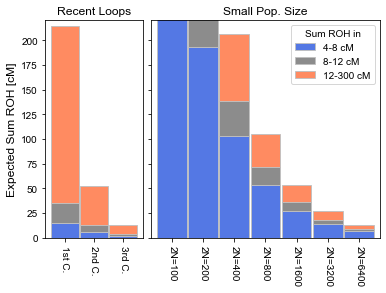

In [44]:
plot_legend_only(savepath="./figures/manuscript/supplement/bar_expectations.pdf", figsize=(6,4))

## Do the Plot for empirical data

### Roman Data Row

Saved figure to ./figures/roman_pilot.pdf


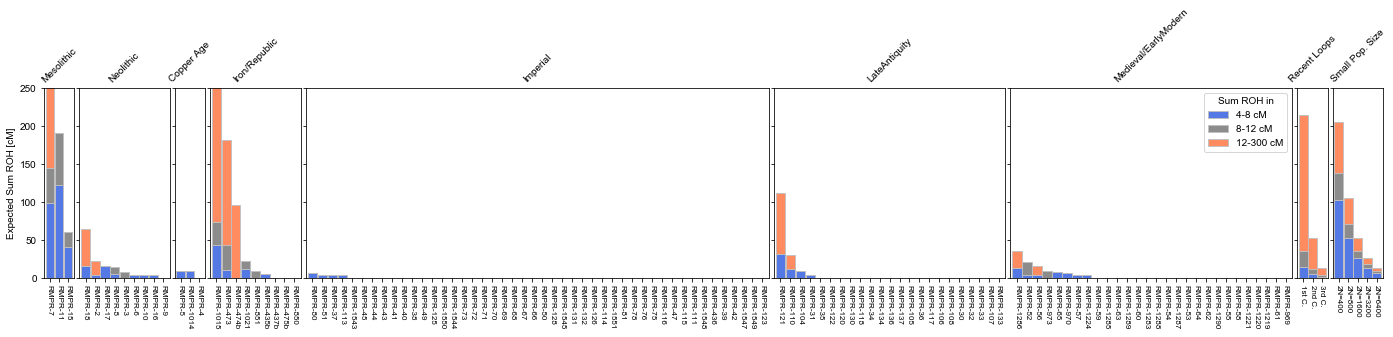

In [48]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Rome"]
plot_dfs, cols = prepare_dfs_plot(df1)

plot_panel_row(plot_dfs, savepath="./figures/roman_pilot.pdf", 
               wspace=0.035, r_title=45, leg_pos=-1)

## Iberia transect Row

In [42]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1 = df1[df1["region"]=="Iberia"]
plot_dfs1, cols = prepare_dfs_plot(df1)

Saved figure to ./figures/iberia_pilot.pdf


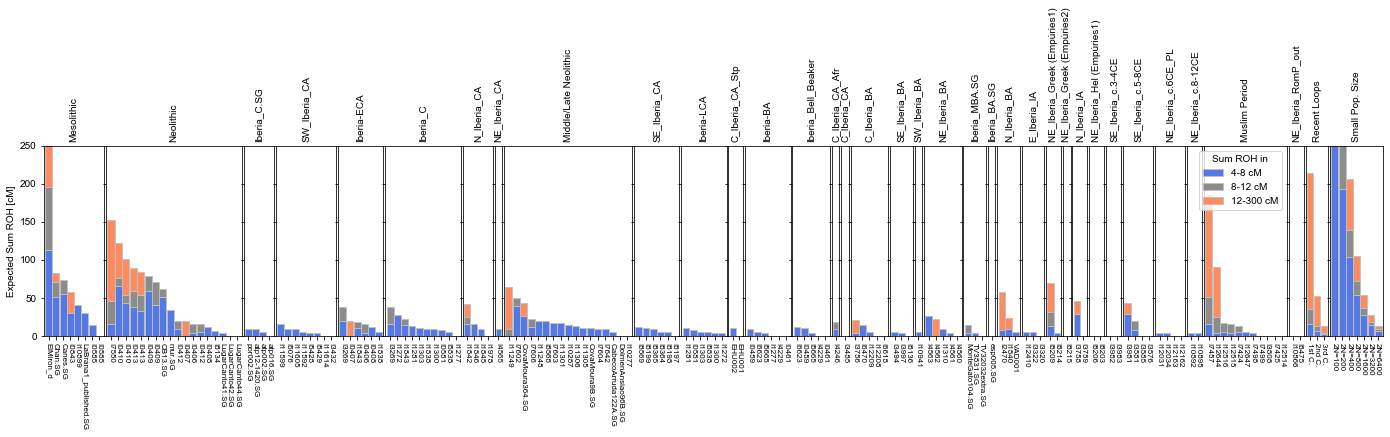

In [43]:
plot_panel_row(plot_dfs1, savepath="./figures/iberia_pilot.pdf")

# Do for Human Origins Dataset

In [97]:
df1 = pd.read_csv("./Empirical/HO/CombinedROH/combinedroh.csv", sep='\t')

,iid,pop,max_roh,sum_roh,n_roh,lat,lon,age
0,Surui_0,Surui,45.051694,699.549421,48,-11.0,-62.0,0.0
1,Karitiana_11,Karitiana,71.722305,617.914425,37,-10.0,-63.0,0.0


# Make Summary Plot

In [100]:
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
df1["region"].value_counts()

Balkans           315
Central Europe    246
Britain           240
Steppe            230
Iberia            159
all               157
Rome              121
Aegan              86
Sardinia           82
Baltic Sea         74
Black Sea          30
Levante            27
Andean             25
Vanuatu            19
Pacific NW         16
Atlantic Coast     15
Patagonia           8
North Africa        5
Name: region, dtype: int64

### What to plot

## Mesoltihic Iberia, Early Neolithic, Middle Neolithic
## Italian Mesolithic, Neolithic
## Central European HG, Neolithic
## Anatolia N
## Balkan HG, Neolithic

### South America?

### HO: Examples: Pakistan, South America, Europe, Chinese


### To plot (to stay flexible):
# Give list of lists (for each row) of plot_dfs (each of them pre-processed)
# Code to plot rows

### Todo: 
- Pre-Process the data
- Write the Plotting engine

In [ ]:
df1[]

# Area 51

In [109]:
### Pilot to Plot multiple rows

In [20]:
def plot_panel_2d(plot_dfs, gs=0):
    """Plot 2D Panel of Bar Plots for ROH"""
    raise NotImplementedError("pls do this")

def prep_gridspecs_2d(dim_list, fig, height_ratios=[]):
    """Prepare Gridspec objects.
    Return list of list of axis to plot on. 
    dim_list: List of Dimensions [integer list] for each row)
    fig: Figure Object on where to do it
    height_ratios: Ratios of the Heights of rows"""
    if len(height_ratios)==0:
        height_ratios = [1 for _ in dim_list]
        
    gs = gridspec.GridSpec(len(dim_list), 1, height_ratios=height_ratios, figure=fig)
    
    ax_list = []
    for i,d in enumerate(dim_list):
        gss = gs[i].subgridspec(1, len(d), width_ratios=d)   # Do the width_ratios here!!
        ax_list0 = [plt.subplot(g) for g in gss] # Create Axis Objects
        ax_list.append(ax_list0)
    return ax_list, gs

In [223]:
def plot_panel_roh_bars(plot_dfs, figsize=(24,6), wspace=2.0, hspace=2.0, 
                        ylim=[0,600], r_title=90):
    """Plot a panel of ROH Bars.
    plot_all_dfs: Lis"""
    fig = plt.figure(figsize=figsize)
    
    dim_list = [list(map(len,ls)) for ls in plot_dfs]
    ax_list, gs = prep_gridspecs_2d(dim_list, fig)

    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes

    for j, df_row in enumerate(plot_dfs): 
        for i, df in enumerate(df_row):   
            if i==0:
                ytick=True
            else:
                ytick=False

            if i == (len(df_row) + leg_pos):
                legend=True
            else:
                legend=False

            ax = ax_list[j][i]
            obs_roh = df[cols].values
            obs_roh[:,0] = obs_roh[:,0] - obs_roh[:,1]
            obs_roh[:,1] = obs_roh[:,1] - obs_roh[:,2]
            obs_roh[:,2] = obs_roh[:,2]

            plot_bar_ax(ax, obs_roh, bins_cM, yticks=ytick, legend=legend, r_title=r_title,
                        x_ticks = df["iid"].values, title=df["clst"].values[0], ylim=ylim)
    plt.show()

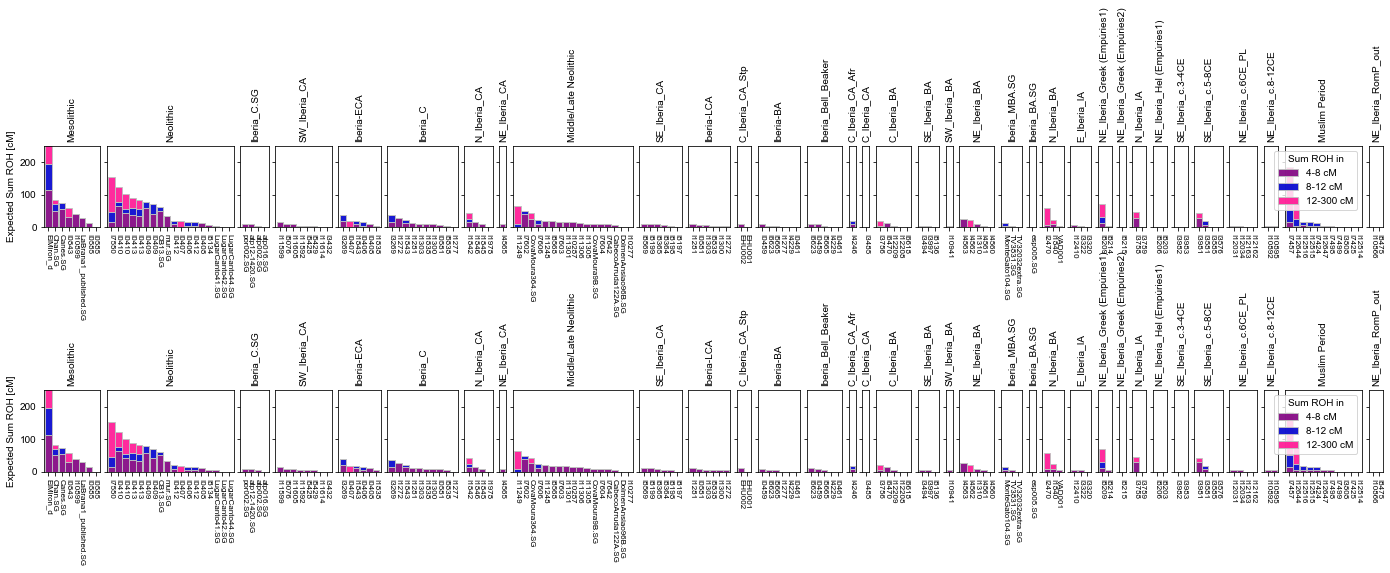

In [167]:
plot_all_dfs = [plot_dfs, plot_dfs1]
plot_panel_roh_bars(plot_all_dfs)

### Combine some interesting Pops

In [40]:
### SA Row
df1 = pd.read_csv("./Empirical/roh_all_inds.csv", sep='\t')
sa_clsts = ["Pacific NW", "Andean", "Atlantic Coast", "Patagonia"]
df_plot = df1[df1["region"].isin(sa_clsts)].copy()
plot_dfs, cols = prepare_dfs_plot(df_plot, col_group="region")

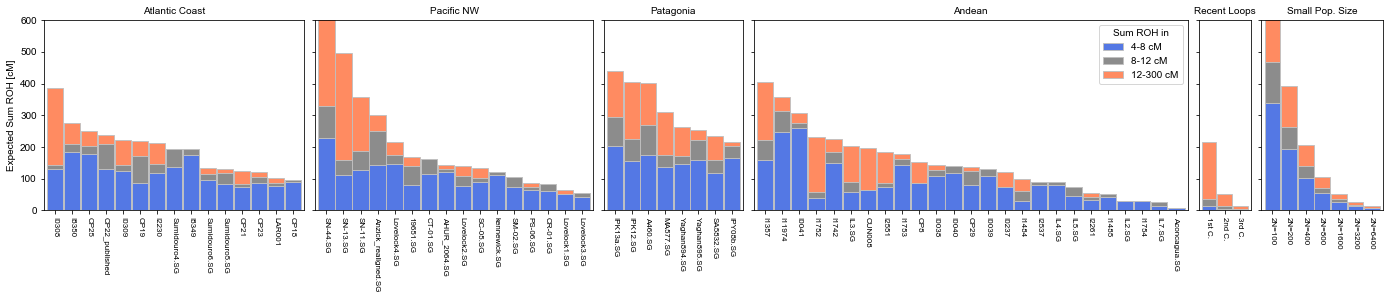

In [41]:
plot_panel_row(plot_dfs, r_title=0, ylim=[0,600], title_col="region", leg_pos=-1)

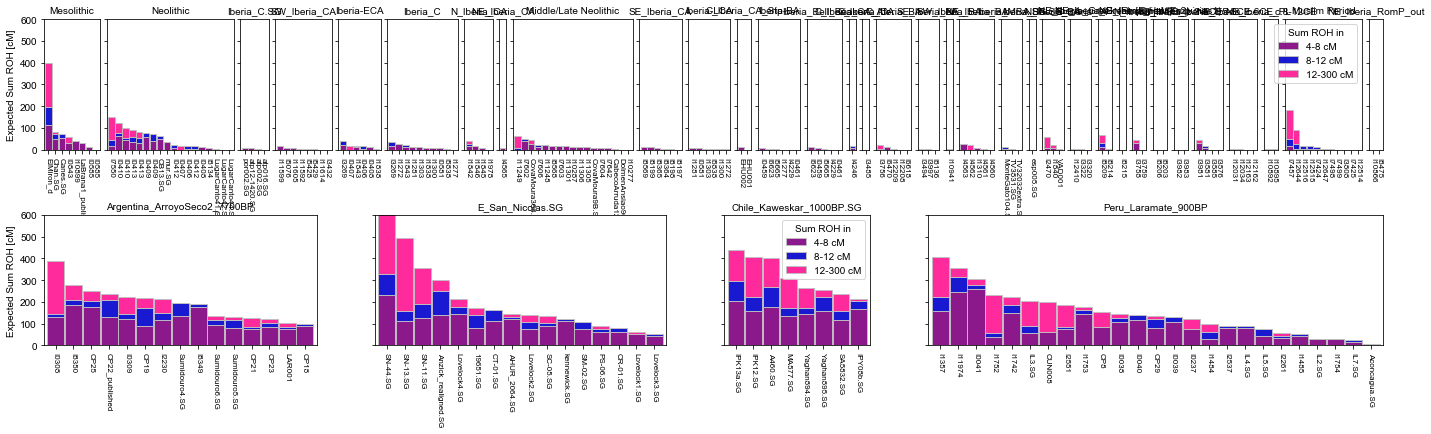

In [229]:
plot_panel_roh_bars([plot_dfs1, plot_dfs], ylim=[0,600], r_title=0, hspace=0.5)